In [1]:
%pip install contractions
%pip install word2number
%pip install unidecode
%pip install num2words
%pip install accelerate
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn
%pip install spacy
%pip install wordcloud
%pip install imblearn
%pip install inflect

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
import re
import spacy
import collections
import nltk
from nltk.stem import WordNetLemmatizer
import wordcloud
from wordcloud import WordCloud
from collections import Counter
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
import contractions
from word2number import w2n
import unidecode
from sklearn.metrics import ConfusionMatrixDisplay
import num2words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import inflect
from tensorflow.keras.layers import Dropout
from sklearn.metrics import roc_curve, auc
from nltk import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import precision_recall_curve, average_precision_score
plt.rcParams['figure.figsize'] = (12,5)
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\magas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\magas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\magas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Wstępna analiza

W ninejszym badaniu stworzę modele służące do analizy sentymentu wykrywające toksyczne tweety.

W badaniu wykorzystałem dataset [Toxic Tweets Dataset
](https://www.kaggle.com/datasets/ashwiniyer176/toxic-tweets-dataset)

Dataset zawiera informacje o tweetach (jego treść) oraz label przyjmujący wartość 0 lub 1 określający czy dany tweet jest toksyczny czy też nie. Komentarze pochodzą z platformy twitter przez co tweety zawierają typowe zwroty dla tej platformy




In [2]:
df = pd.read_csv("./FinalBalancedDataset.csv")
df.drop(columns = ["Unnamed: 0"], inplace=True)
df.tail()

,Toxicity,tweet
56740,1,"you's a muthaf***in lie &#8220;@LifeAsKing: @20_Pearls @corey_emanuel right! His TL is trash &#8230;. Now, mine? Bible scriptures and hymns&#8221;"
56741,1,"you've gone and broke the wrong heart baby, and drove me redneck crazy"
56742,1,young buck wanna eat!!.. dat nigguh like I aint fuckin dis up again
56743,1,youu got wild bitches tellin you lies
56744,0,"~~Ruffled | Ntac Eileen Dahlia - Beautiful color combination of pink, orange, yellow &amp; white. A Coll http://t.co/H0dYEBvnZB"


Ponieżej mozemy zaobserować że kolumna Toxicity przyjmuje wartości od 0 do 1. Dane nie zawierają pustych wartości. Ponieżej przedstawiono listę unikalnych znaków. Dataset składa się z 109204 unikalnych słów oraz poniżej można zobaczyć listę najpopularniejszych słów.

In [3]:
df.info()
print("Unique classes:\n",df['Toxicity'].unique())
print("Empty values:\n",df.isnull().sum())
print("Unique chars: ", set(df['tweet'].sum()))
results = set()
df['tweet'].str.lower().str.split().apply(results.update)
print("Unique words: ", len(results))
print("Most popular word: ", Counter(" ".join(df['tweet'].str.lower()).split()).most_common(100))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56745 entries, 0 to 56744
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Toxicity  56745 non-null  int64 
 1   tweet     56745 non-null  object
dtypes: int64(1), object(1)
memory usage: 886.8+ KB
Unique classes:
 [0 1]
Empty values:
 Toxicity    0
tweet       0
dtype: int64
Unique chars:  {'\x8f', '×', '?', '¸', 'o', '¤', 'Z', '¶', 'G', 'µ', 'x', ')', 'à', '§', "'", '\n', '\xad', '¦', '\x90', '\x8a', '\x8c', 'Ñ', '~', ' ', '\x94', 'è', 'O', '\x82', 'º', '\x98', '0', 'ë', 'E', '^', 'q', '\x92', '\x8e', 'I', '£', '3', '1', 'F', 'ð', 'æ', 'ó', 'A', 'g', 'n', '$', 'á', 'X', 'u', ',', '7', '\x89', '&', 'y', '9', '-', 'î', 'ã', 'ì', '\x85', ']', 't', 'L', 'i', '\x9a', '¼', '"', 'e', '»', 'â', '\x9c', '\x87', '¿', 'Î', 'ò', 'Â', 'ê', 'N', '+', 'ä', 'K', '!', '}', 'm', 'Ð', 'h', 'l', 'v', 'Ë', '©', '«', '\x93', 'b', 'c', '²', '{', '\xa0', '¹', 'í', 'W', 'Ä', 'Y', '¬', '\x8b', 'r'

In [244]:
#print(df[df.duplicated(['tweet'], keep=False)].to_string())

Usunięto duplikaty przez co dataset zmniejszył się z 56745 do 54313

In [5]:
#delete duplicates
print(df.shape)
df = df.drop_duplicates(subset=['tweet'])
print(df.shape)


(56745, 2)
(54313, 2)


Przedstawiono przykład tweetów nie zaklasyfikowanych jako toksyczne

In [6]:
# Example of not toxic tweets
df[df['Toxicity'] == 0].head(10)

,Toxicity,tweet
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,0,bihday your majesty
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,0,factsguide: society now #motivation
5,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo
6,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
7,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦
9,0,@user @user welcome here ! i'm it's so #gr8 !


Przedstawiono przykład tweetów zaklasyfikowanych jako toksyczne

In [7]:
# Example of not toxic tweets
df[df['Toxicity'] == 1].head(10)

,Toxicity,tweet
13,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,1,retweet if you agree!
23,1,@user @user lumpy says i am a . prove it lumpy.
34,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia
56,1,@user lets fight against #love #peace
68,1,ð©the white establishment can't have blk folx running around loving themselves and promoting our greatness
77,1,"@user hey, white people: you can call people 'white' by @user #race #identity #medâ¦"
82,1,how the #altright uses &amp; insecurity to lure men into #whitesupremacy
111,1,@user i'm not interested in a #linguistics that doesn't address #race &amp; . racism is about #power. #raciolinguistics bringsâ¦


Przedstawiono najpopularniejsze słowa w całym datasecie 

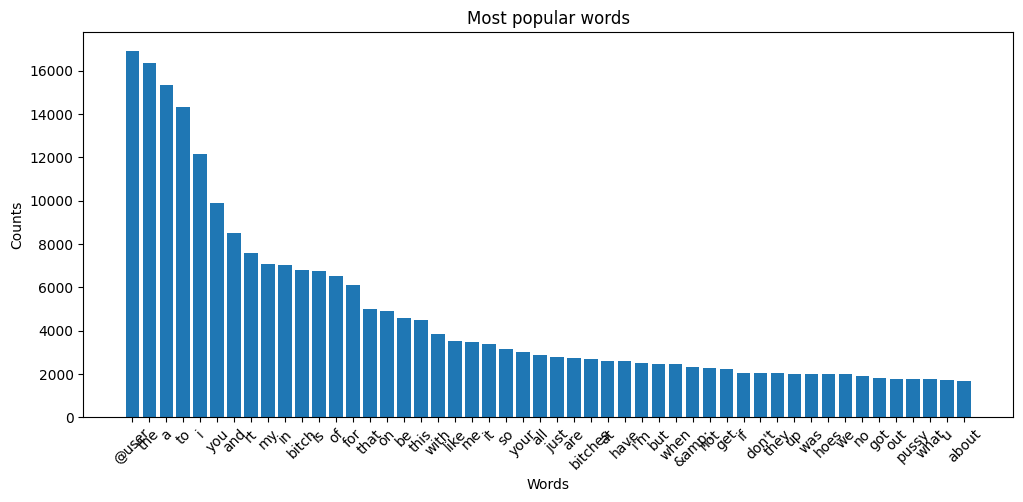

In [9]:
most_popular_words = Counter(" ".join(df['tweet'].str.lower()).split()).most_common(50)
words = [item[0] for item in most_popular_words]
counts = [item[1] for item in most_popular_words]
plt.bar(words, counts)
plt.xlabel("Words")
plt.ylabel("Counts")
plt.title("Most popular words")
plt.xticks(rotation=45)
plt.show()

Przedstawiono dystrybucję klas. Można zaobserwować że dataset jest zbalasowany. Nie ma dużej róznicy pomiedzy toksycznymi a nie toksycznymi tweetami.

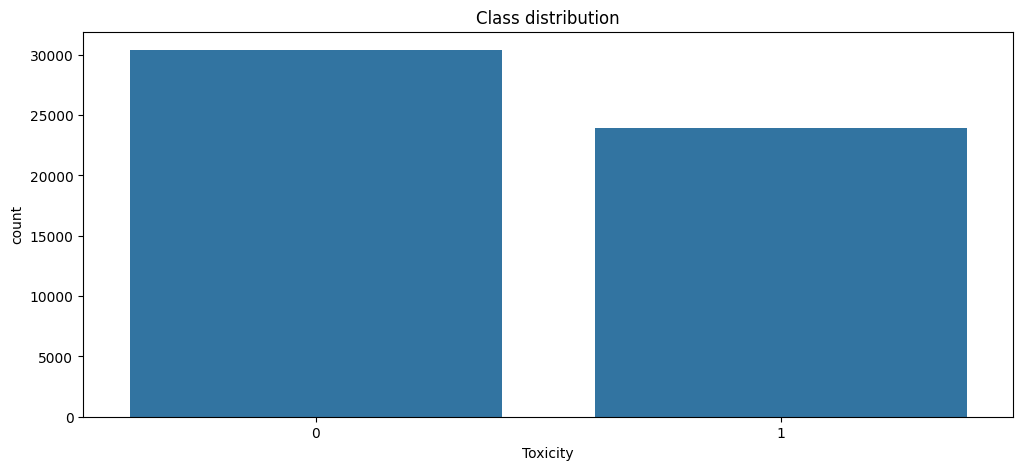

In [8]:
# classes distribution
sns.countplot(x = "Toxicity", data = df)
plt.title("Class distribution")
plt.show()

Przedstawiono najpopularniejsze słowa wsród nie toksycznych tweetów

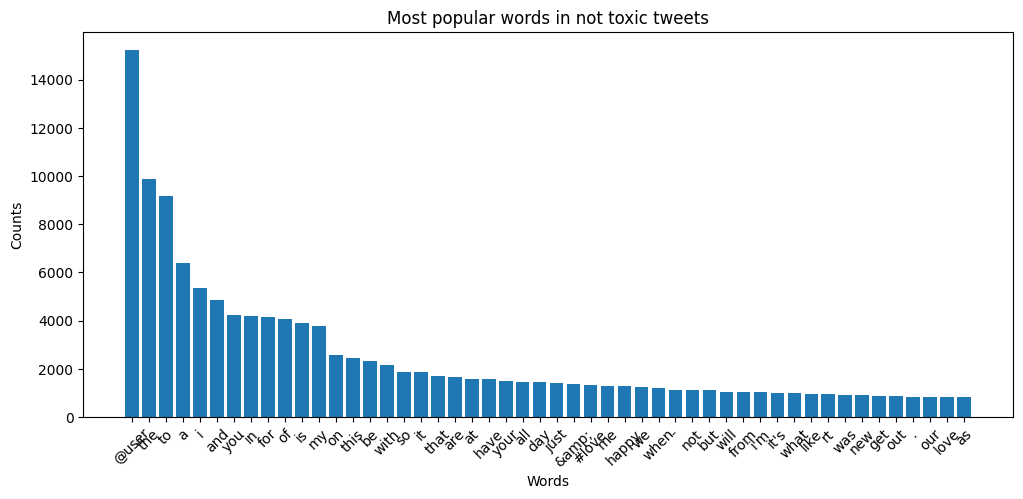

In [10]:
most_popular_words = Counter(" ".join(df[df['Toxicity']==0]["tweet"].str.lower()).split()).most_common(50)
words = [item[0] for item in most_popular_words]
counts = [item[1] for item in most_popular_words]
plt.bar(words, counts)
plt.xlabel("Words")
plt.ylabel("Counts")
plt.title("Most popular words in not toxic tweets")
plt.xticks(rotation=45)
plt.show()

Przedstawiono najpopularniejsze słowa wsród toksycznych tweetów

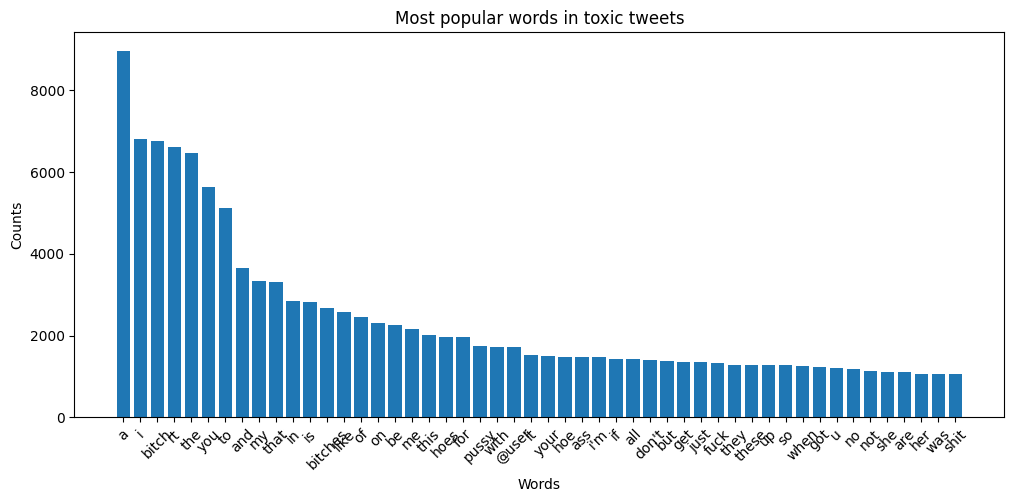

In [11]:
most_popular_words = Counter(" ".join(df[df['Toxicity']==1]["tweet"].str.lower()).split()).most_common(50)
words = [item[0] for item in most_popular_words]
counts = [item[1] for item in most_popular_words]
plt.bar(words, counts)
plt.xlabel("Words")
plt.ylabel("Counts")
plt.title("Most popular words in toxic tweets")
plt.xticks(rotation=45)
plt.show()

Przedstawiono najpopularniejsze słowa w sposób graficzny wsród nie toksycznych, toksycznych tweetów oraz w całym datasecie. Można zaobserwować że wsród toksycznych tweetów bardziej popularne są przekleństwa i wyzwiska. Można również zwrócić uwagę na pojedyncze tokeny lub słowa jak @user, rt typowe dla platformy twitter. Będzie to ważne w dalszej analizie.

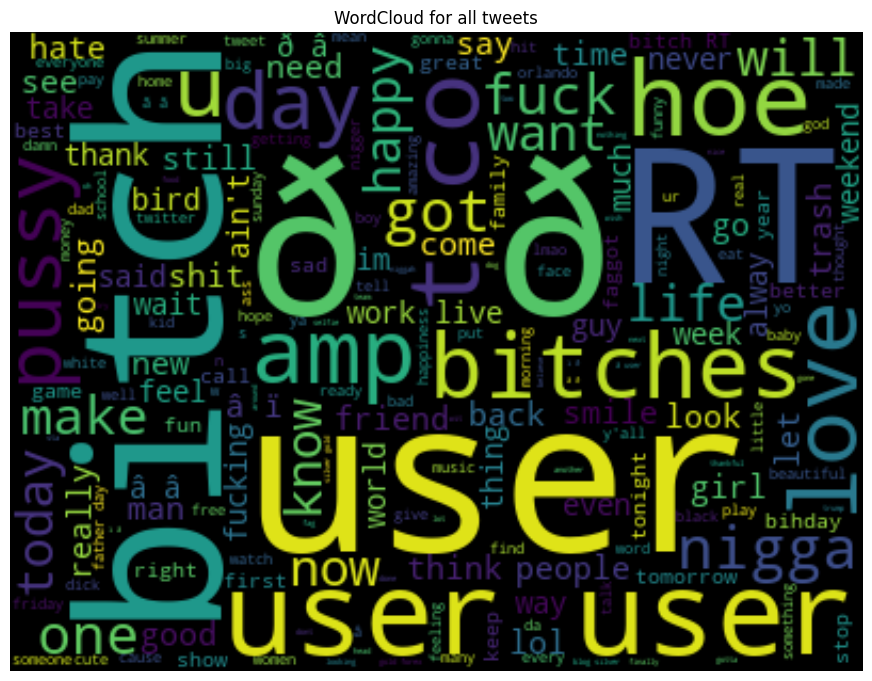

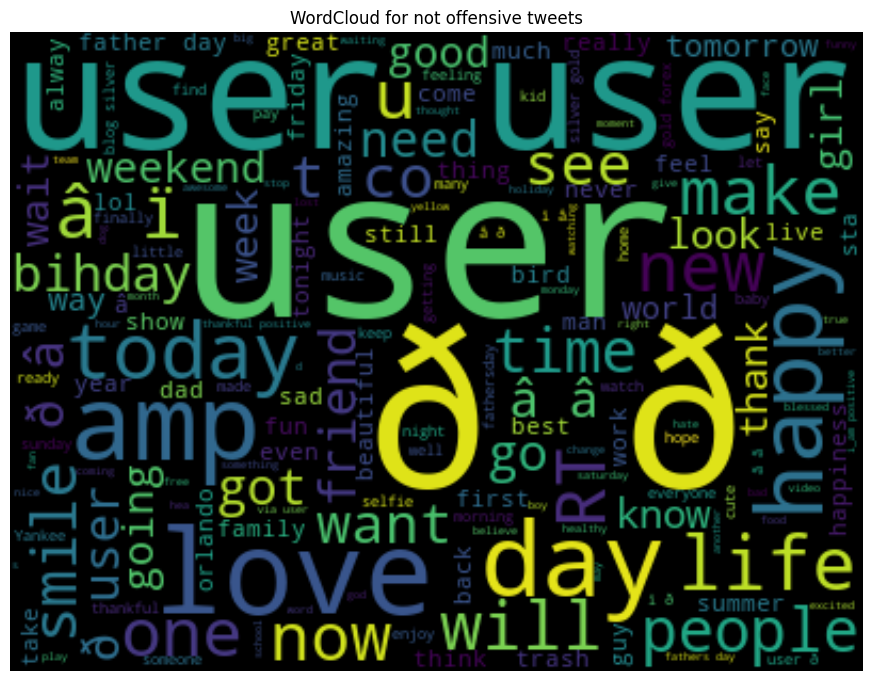

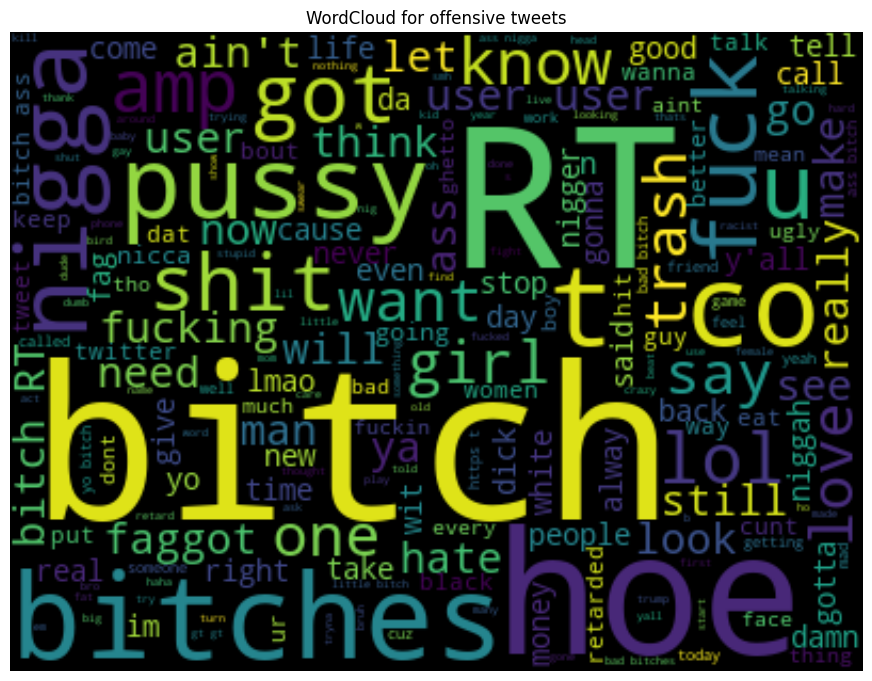

In [12]:
tweets_ALL = ' '.join([tweet for tweet in df['tweet']])
tweets_NOT = ' '.join([tweet for tweet in df[df['Toxicity'] == 0]['tweet']])
tweets_OFF = ' '.join([tweet for tweet in df[df['Toxicity'] == 1]['tweet']])
wordCloud = WordCloud(width=400, height=300, random_state=100, max_font_size=100).generate(tweets_ALL)
plt.figure(figsize=(11, 9))
plt.axis('off')
plt.imshow(wordCloud, interpolation="bilinear")
plt.title("WordCloud for all tweets")
plt.show()
wordCloud = WordCloud(width=400, height=300, random_state=100, max_font_size=100).generate(tweets_NOT)
plt.figure(figsize=(11, 9))
plt.axis('off')
plt.imshow(wordCloud, interpolation="bilinear")
plt.title("WordCloud for not offensive tweets")
plt.show()
wordCloud = WordCloud(width=400, height=300, random_state=100, max_font_size=100).generate(tweets_OFF)
plt.figure(figsize=(11, 9))
plt.axis('off')
plt.imshow(wordCloud, interpolation="bilinear")
plt.title("WordCloud for offensive tweets")
plt.show()

Obliczono statystyki opisowe oraz przedstawiono wykresy pudełkowe oraz histogramy określajaće ilość słów. Możemy zauważyć że histogramy jak i wykresy pudełkowe dla toksycznych i nie toksycznych tweetów są bardzo podobne do siebie. Główne statystyki jak średnia, odchylenie oraz mediana praktycznie nie różnią się dla tych dwóch grup.

In [16]:
df['number_of_words'] = df['tweet'].str.split().apply(len)
print("Descriptive statistics for words in all tweets:", df["number_of_words"].describe(), "\n")
print("Descriptive statistics for words in not offensive tweets: \n", df[df['Toxicity'] == 0]["number_of_words"].describe(), "\n")
print("Descriptive statistics for words in offensive tweets: \n", df[df['Toxicity'] == 1]["number_of_words"].describe(), "\n")

Descriptive statistics for words in all tweets: count    54313.000000
mean        13.648592
std          6.180789
min          1.000000
25%          9.000000
50%         13.000000
75%         18.000000
max         52.000000
Name: number_of_words, dtype: float64 

Descriptive statistics for words in not offensive tweets: 
 count    30389.000000
mean        13.353582
std          5.724713
min          1.000000
25%          9.000000
50%         13.000000
75%         17.000000
max         52.000000
Name: number_of_words, dtype: float64 

Descriptive statistics for words in offensive tweets: 
 count    23924.000000
mean        14.023324
std          6.697009
min          1.000000
25%          9.000000
50%         13.000000
75%         19.000000
max         36.000000
Name: number_of_words, dtype: float64 



Obliczono statystyki opisowe oraz przedstawiono wykresy pudełkowe oraz histogramy określajaće długość wpisów. Możemy zauważyć że histogramy jak i wykresy pudełkowe dla toksycznych i nie teoksycznych tweetów są bardzo podobne do siebie. Można zauważyć większą ilość wartości odstających w przypadku toksycznych tweetów. Główne statystyki jak średnia, odchylenie oraz mediana praktycznie nie różnią się dla tych dwóch grup.

In [13]:
#descriptive statistics
df['tweet_length'] = df['tweet'].apply(len)
print("Descriptive statistics for all tweets: \n", df["tweet_length"].describe(), "\n")
print("Descriptive statistics for not offensive tweets: \n", df[df['Toxicity'] == 0]["tweet_length"].describe(), "\n")
print("Descriptive statistics for offensive tweets: \n", df[df['Toxicity'] == 1]["tweet_length"].describe(), "\n")

Descriptive statistics for all tweets: 
 count    54313.000000
mean        85.340839
std         35.685636
min          5.000000
25%         57.000000
50%         87.000000
75%        111.000000
max        754.000000
Name: tweet_length, dtype: float64 

Descriptive statistics for not offensive tweets: 
 count    30389.000000
mean        85.858107
std         31.334397
min          7.000000
25%         62.000000
50%         89.000000
75%        109.000000
max        522.000000
Name: tweet_length, dtype: float64 

Descriptive statistics for offensive tweets: 
 count    23924.000000
mean        84.683790
std         40.536087
min          5.000000
25%         52.000000
50%         82.000000
75%        116.000000
max        754.000000
Name: tweet_length, dtype: float64 



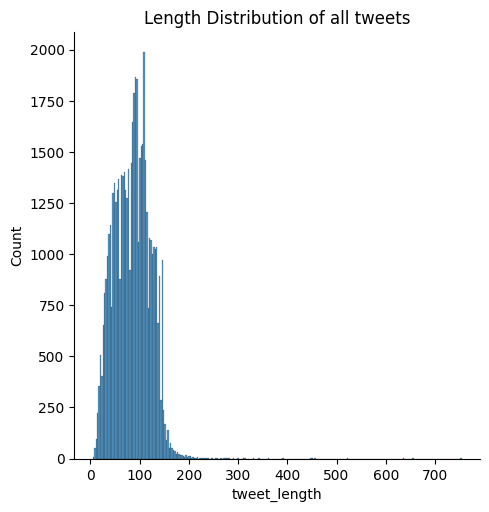

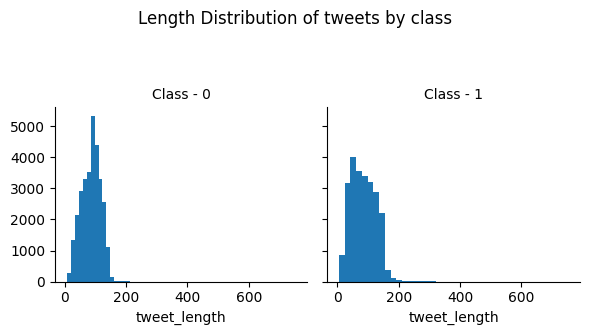

In [14]:
sns.displot(df['tweet_length'])
plt.title("Length Distribution of all tweets")
plt.show()

graph = sns.FacetGrid(data=df, col='Toxicity')
graph.map(plt.hist, 'tweet_length', bins=40)
graph.set_titles("Class - {col_name}")
plt.suptitle("Length Distribution of tweets by class", y=1.1)
plt.tight_layout()

plt.show()

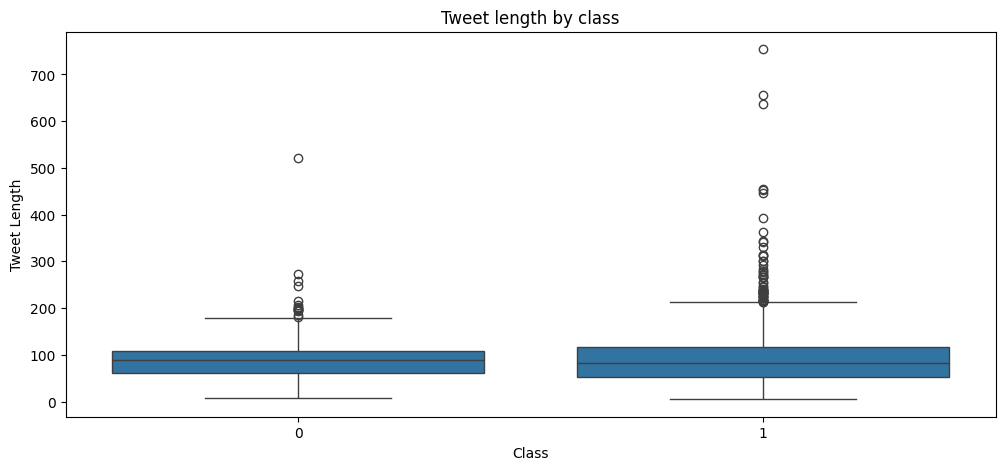

In [15]:
sns.boxplot(y='tweet_length', x='Toxicity', data=df)
plt.title("Tweet length by class")
plt.xlabel("Class")
plt.ylabel("Tweet Length")

plt.show()

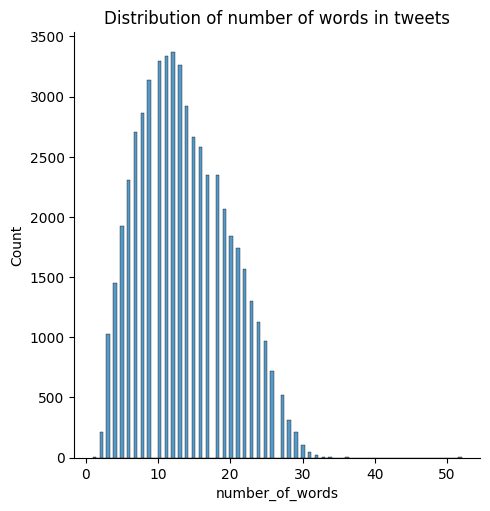

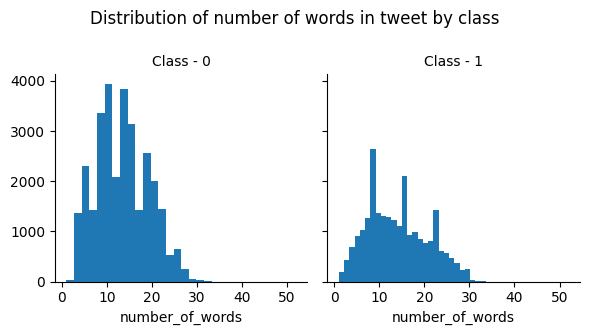

In [17]:
sns.displot(df['number_of_words'])
plt.title("Distribution of number of words in tweets")
plt.show()

graph = sns.FacetGrid(data=df, col='Toxicity')
graph.map(plt.hist, 'number_of_words', bins=30)
graph.set_titles("Class - {col_name}")
plt.suptitle("Distribution of number of words in tweet by class", y=1.1)

plt.show()

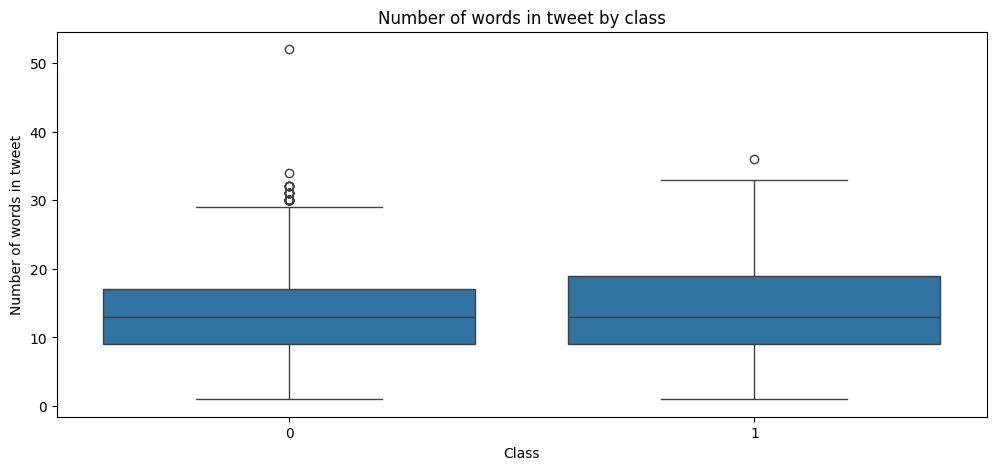

In [18]:
sns.boxplot(y='number_of_words', x='Toxicity', data=df)
plt.title("Number of words in tweet by class")
plt.xlabel("Class")
plt.ylabel("Number of words in tweet")

plt.show()

# Czyszczenie danych

Stworzyłem klase zawierająca metody do obróbki danych.

In [19]:
class cleanup:
    def toLower(tweet: str) -> str:
        return tweet.lower()
    
    def clear_chars(tweet: str) -> str:
        tweet = re.sub(r'@user', '', tweet)
        tweet = re.sub(r'url', '', tweet)
        tweet = re.sub(r'#\w+','', tweet)
        tweet = re.sub(r'@\w+','', tweet)
        tweet = re.sub(r'&\w+','', tweet)
        tweet = re.sub(r'http\S+', ' ', tweet)
        # tweet = re.sub(r'[.,\'!?;:_-]', '', tweet)
        return tweet
    
    def remove_emoji_and_special_signs(tweet: str) -> str:
        tweet = unidecode.unidecode(tweet)
        return tweet
    
    def modify_whitespaces(tweet: str) -> str:
        tweet = re.sub(' +',' ', tweet)
        return tweet
    
    def expand_contractions(tweet: str) -> str:
        tweet = contractions.fix(tweet)
        return tweet
    
    def tokenize(tweet: str) -> list:
        tokenized_tweet = nltk.word_tokenize(tweet)
        return tokenized_tweet
    
    def modify_numbers(word_list: list) -> list:
        engine = inflect.engine()
        return [engine.number_to_words(word) if word.isdigit() else word for word in word_list]
    
    def clear_special_tokens(tweet: list) -> list:
        return [re.sub(r'[^\w\s]', '', word) for word in tweet if word != '']
    
    def remove_stop_words(tweet: list) -> list:
        stop_words_extended = ["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]
        tweet = [word for word in tweet if word not in stop_words_extended]
        return tweet
    
    def remove_twitter_tags(tweet: list) -> list:
       return [word for word in tweet if word not in ("ff", "rt")]
    
    def lemmatize(word_list: list) -> list:
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(word) for word in word_list]
    
    def join_list(list_of_words: list) -> str:
        return ' '.join(list_of_words).strip()
    



Dane zostały podzielone na tweety i kolumne odpowiedzialną za klasyfikacje toksycznych tweetów.

Tweety najpierw zostały zmodyfikowane poprzez zmniejszenie wielkosci liter i ujednolicenie ich do małych liter. Następnie wyszczyone zostały znaki specjalne  jak i specjalne tagi jak @user, url, linki hashtagi oraz oznaczenia. Potem usunięte zostały inne znaki specjalne oraz emocji dzięki użyciu encodingu. Następnie usunięto wielokrotne spacje. Potem rozwinięto skróty i przeprowadzono tokenizacje. Następnie zmodyfikowano numery do wartości tekstowych. Usunięto specjalne tokeny jak przecinki. Usunięto również stop wordsy oraz tagi twitterowe jak rt lub ff.

Po normalizacji przeprowadzono lematyzację, czyli sprowadzenie słów do ich podstawowych form, uwzględniając ich gramatyczny kontekst oraz połączono zdania z tokenów z listy.

Poniżej można zaobserwować listę unikalnych liter oraz zredukowo liczbę słów do 33145.

In [20]:
X = df['tweet'].copy()
y = df['Toxicity'].copy()

print("Lowercase:\n")
print(X.head(5))
X_lower_case = X.apply(cleanup.toLower)
print(X_lower_case.head(5))

print("Clear chars:\n")
X_cleared = X_lower_case.apply(cleanup.clear_chars)
print(X_cleared.head(5))

print("Remove emoji and special signs:\n")
X_remove_emoji = X_cleared.apply(cleanup.remove_emoji_and_special_signs)
print(X_remove_emoji.head(5))

print("Whitespaces:\n")
X_whitespaces = X_remove_emoji.apply(cleanup.modify_whitespaces)
print(X_whitespaces.head(5))

print("Expand contractions:\n")
X_expand_contractions = X_whitespaces.apply(cleanup.expand_contractions)
print(X_expand_contractions.head(5))

print("Tokenization:\n")
X_tokenized = X_expand_contractions.apply(cleanup.tokenize)
print(X_tokenized.head(5))

print("Modify numbers:\n")
X_numbers = X_tokenized.apply(cleanup.modify_numbers)
print(X_numbers.head(5))

print("Special tokens:\n")
X_special_tokens = X_numbers.apply(cleanup.clear_special_tokens)
print(X_special_tokens.head(5))

print("Stop words:\n")
X_stop_words = X_special_tokens.apply(cleanup.remove_stop_words)
print(X_stop_words.head(5))

print("Twitter tags:\n")
X_tags = X_stop_words.apply(cleanup.remove_twitter_tags)
print(X_tags.head(5))

print("Lematization:\n")
X_lemmatized = X_tags.apply(cleanup.lemmatize)
print(X_lemmatized.head(5))

print("Join from list:\n")
X_joined = X_lemmatized.apply(cleanup.join_list)
print(X_joined.head(5))

X_w = X_joined.apply(cleanup.modify_whitespaces)
X_prepared = X_w.apply(cleanup.toLower)

print("Unique chars", set(X_prepared.sum()))
print("Unique words: ", len(set(X_prepared.str.split().explode())))

Lowercase:

0                         @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
1    @user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
2                                                                                                           bihday your majesty
3                                        #model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦  
4                                                                                        factsguide: society now    #motivation
Name: tweet, dtype: object
0                         @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
1    @user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
2                                                                

In [21]:
print(X_prepared)

0                                           father dysfunctional selfish drag kid dysfunction
1                                                             credit offer wheelchair van pdx
2                                                                              bihday majesty
3                                                                       love time urd ddddddd
4                                                                          factsguide society
                                                 ...                                         
56740                                           muthaf lie tl trash mine bible scripture hymn
56741                                              broke wrong heart baby drove redneck crazy
56742                                                    young buck eat dat nigguh fuckin dis
56743                                                              youu wild bitch tellin lie
56744    ruffled ntac eileen dahlia beautiful color combinat

Przedstawiono najpopularniejsze pozostałe słowa po czyszczeniu danych. Zaprezentowano również mapę słów dla wszystkich 

In [22]:
Counter(" ".join(X_prepared).split()).most_common(10)

[('bitch', 11463),
 ('hoe', 4336),
 ('day', 2840),
 ('pussy', 2270),
 ('nigga', 2052),
 ('love', 1665),
 ('happy', 1661),
 ('as', 1632),
 ('fuck', 1565),
 ('shit', 1408)]

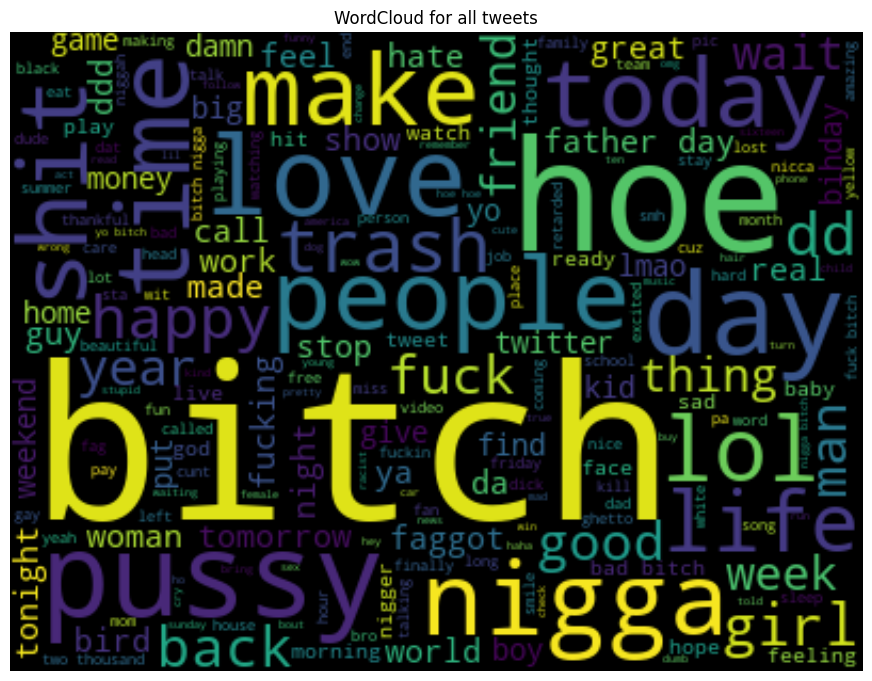

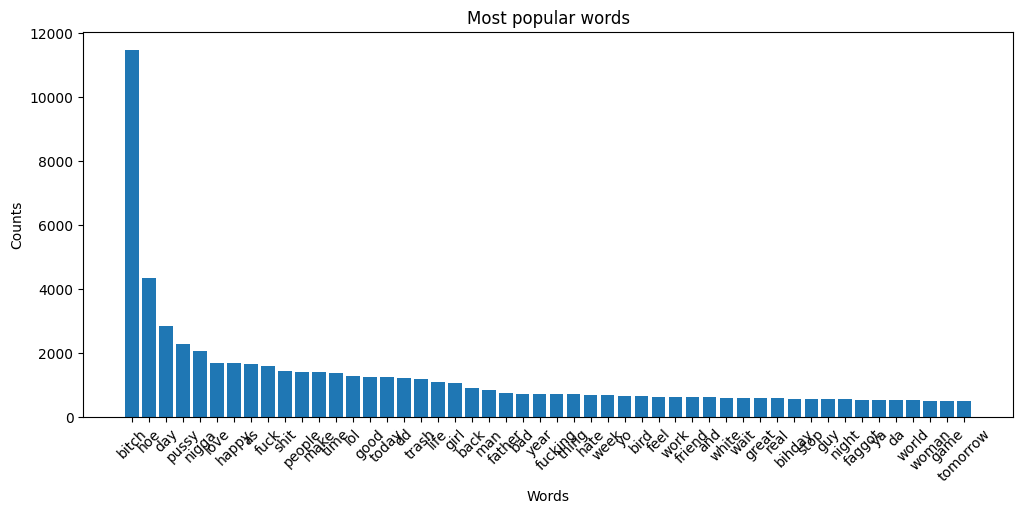

In [23]:
tweets_prepared = ' '.join([tweet for tweet in X_prepared])
wordCloud = WordCloud(width=400, height=300, random_state=100, max_font_size=100).generate(tweets_prepared)
plt.figure(figsize=(11, 9))
plt.axis('off')
plt.imshow(wordCloud, interpolation="bilinear")
plt.title("WordCloud for all tweets")
plt.show()

most_popular_words = Counter(" ".join(X_prepared.str.lower()).split()).most_common(50)
words = [item[0] for item in most_popular_words]
counts = [item[1] for item in most_popular_words]
plt.bar(words, counts)
plt.xlabel("Words")
plt.ylabel("Counts")
plt.title("Most popular words")
plt.xticks(rotation=45)
plt.show()

Ponownie przeanalizowałem wykres pudełkowy oraz dystrybucje ilości słow.

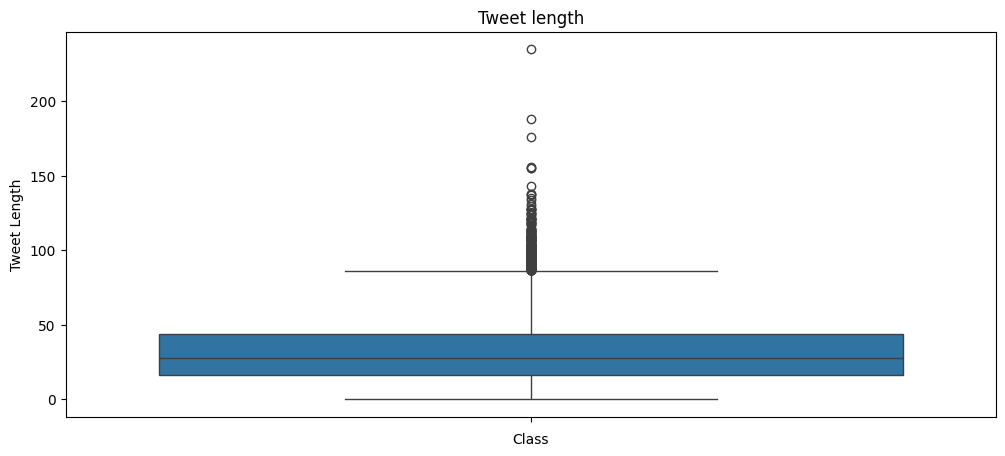

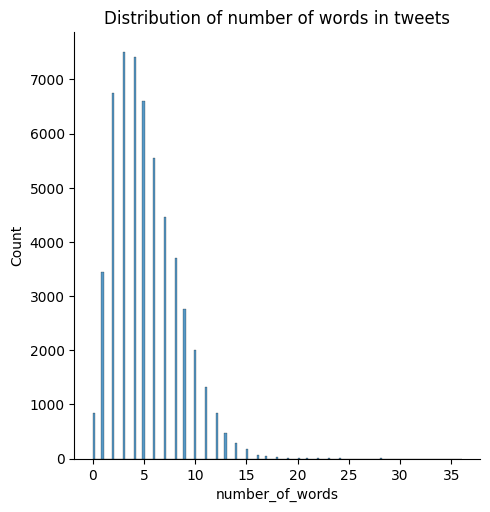

In [24]:
X_prepared_copy = X_prepared.copy()
X_prepared_copy = pd.DataFrame(X_prepared_copy)
X_prepared_copy['tweet_length'] = X_prepared_copy["tweet"].apply(len)

sns.boxplot(y='tweet_length', data=X_prepared_copy)
plt.title("Tweet length")
plt.xlabel("Class")
plt.ylabel("Tweet Length")
plt.show()

X_prepared_copy['number_of_words'] = X_prepared_copy["tweet"].str.split().apply(len)
sns.displot(X_prepared_copy['number_of_words'])
plt.title("Distribution of number of words in tweets")
plt.show()


Wykonano podział na zbiór treningowy, walidacyjny i testowy w proporcji 80:10.10

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.2, random_state=101)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=101)
y_train = tf.convert_to_tensor(y_train)
y_val = tf.convert_to_tensor(y_val)
y_test = tf.convert_to_tensor(y_test)

print(X_train)

29481                                                                         found
50327                                                             hate wcw as bitch
23291                                                              beautiful sweety
11769                                        mood day aai d3mood weekend dpsdaui dd
47907                                       lol foreal yo lmao fuck real talk bitch
                                            ...                                    
5940                                                                 fit capable da
8410                                                                          learn
18965                                                              easy 123 morning
19166                                          nigga watching trash as wwe game wow
48351    charlie baker make final election eve campaign stop swampscott high school
Name: tweet, Length: 43450, dtype: object


In [35]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(43450,)
(5432,)
(5431,)


Wykonanu pretrained word embedding oraz word embedding

In [36]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

X_train_pre = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=128, return_tensors='tf')
X_val_pre = tokenizer(X_val.tolist(), truncation=True, padding=True, max_length=128, return_tensors='tf')
X_test_pre = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=128, return_tensors='tf')

In [38]:
max_features = 10000
embedding_dim = 128
max_len=200
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')
X_val = pad_sequences(X_val, maxlen=max_len, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')

vocabulary_size = len(tokenizer.word_index) + 1

# Modele
 Stworzone zostały cztery modele: LSTM, CNN, model z podstawieniem pre-trained word embeddingów oraz fine-tuning modelu jezyka

## Model LSTM

In [193]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional

embedding_dim = 128
dropout_rate = 0.1
recurrent_dropout_rate = 0.2
lstm_hidden_dim = 200

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=max_len))
lstm_model.add(Bidirectional(LSTM(64)))
lstm_model.add(Dense(units=24, activation='relu'))
lstm_model.add(Dense(units=1, activation='sigmoid'))

optimizer_lstm = tf.keras.optimizers.Adam(learning_rate=0.01)
lstm_model.compile(loss='binary_crossentropy', optimizer=optimizer_lstm, metrics=[tf.keras.metrics.BinaryAccuracy()])
lstm_model_history = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=8)


Epoch 1/5
5432/5432 [==============================] - 570s 105ms/step - loss: 0.2230 - accuracy: 0.9177 - val_loss: 0.1943 - val_accuracy: 0.9280
Epoch 2/5
5432/5432 [==============================] - 548s 101ms/step - loss: 0.1587 - accuracy: 0.9408 - val_loss: 0.2009 - val_accuracy: 0.9249
Epoch 3/5
5432/5432 [==============================] - 570s 105ms/step - loss: 0.1375 - accuracy: 0.9496 - val_loss: 0.2066 - val_accuracy: 0.9260
Epoch 4/5
5432/5432 [==============================] - 543s 100ms/step - loss: 0.1244 - accuracy: 0.9547 - val_loss: 0.2122 - val_accuracy: 0.9216
Epoch 5/5
5432/5432 [==============================] - 543s 100ms/step - loss: 0.1155 - accuracy: 0.9570 - val_loss: 0.2294 - val_accuracy: 0.9207


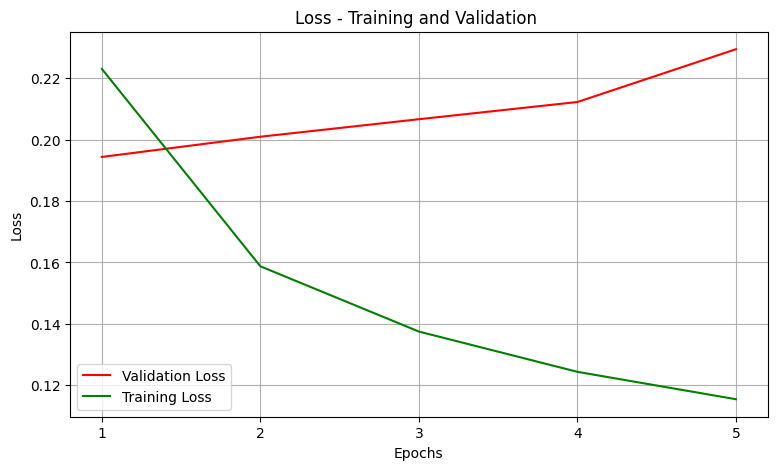

In [181]:
epochs_lstm = range(1, len(lstm_model_history.history['loss']) + 1)
loss_lstm = lstm_model_history.history['loss']
validation_loss_lstm = lstm_model_history.history['val_loss']

plt.figure(figsize=(9, 5))
plt.title('Loss - Training and Validation ')
plt.plot(epochs_lstm, validation_loss_lstm, 'r', label='Validation Loss',)
plt.plot(epochs_lstm, loss_lstm, 'g', label='Training Loss',)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend()

plt.xticks(range(1, 6))

plt.show()

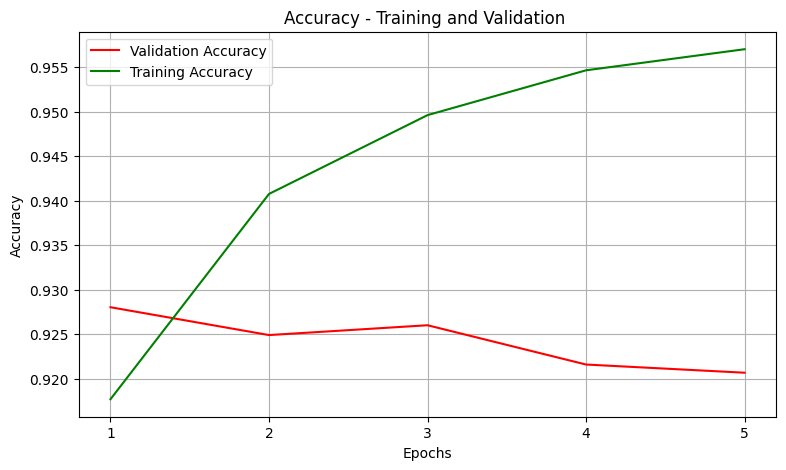

In [114]:

epochs_lstm = range(1, len(lstm_model_history.history['loss']) + 1)
accuracy_lstm = lstm_model_history.history['binary_accuracy']
validation_accuracy_lstm = lstm_model_history.history['val_binary_accuracy']

plt.figure(figsize=(9, 5))
plt.title('Accuracy - Training and Validation ')
plt.plot(epochs_lstm, validation_accuracy_lstm, 'r', label='Validation Accuracy',)
plt.plot(epochs_lstm, accuracy_lstm, 'g', label='Training Accuracy',)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend()

plt.xticks(range(1, 6))

plt.show()

## Model CNN


In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=max_len))
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(units=64, activation='relu'))
cnn_model.add(Dense(units=1, activation='sigmoid'))

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_model_history = cnn_model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=8)





Epoch 1/5
5432/5432 [==============================] - 107s 20ms/step - loss: 0.2060 - accuracy: 0.9227 - val_loss: 0.1664 - val_accuracy: 0.9376
Epoch 2/5
5432/5432 [==============================] - 111s 20ms/step - loss: 0.1006 - accuracy: 0.9648 - val_loss: 0.2122 - val_accuracy: 0.9332
Epoch 3/5
5432/5432 [==============================] - 110s 20ms/step - loss: 0.0453 - accuracy: 0.9856 - val_loss: 0.2543 - val_accuracy: 0.9234
Epoch 4/5
5432/5432 [==============================] - 107s 20ms/step - loss: 0.0256 - accuracy: 0.9918 - val_loss: 0.3719 - val_accuracy: 0.9166
Epoch 5/5
5432/5432 [==============================] - 109s 20ms/step - loss: 0.0176 - accuracy: 0.9941 - val_loss: 0.4314 - val_accuracy: 0.9201


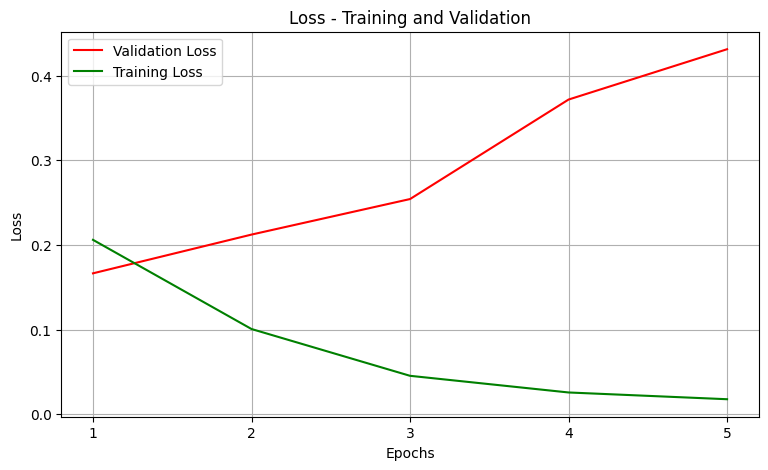

In [113]:
epochs_cnn = range(1, len(cnn_model_history.history['loss']) + 1)
loss_cnn = cnn_model_history.history['loss']
validation_loss_cnn = cnn_model_history.history['val_loss']

plt.figure(figsize=(9, 5))
plt.title('Loss - Training and Validation')
plt.plot(epochs_cnn, validation_loss_cnn, 'r', label='Validation Loss',)
plt.plot(epochs_cnn, loss_cnn, 'g', label='Training Loss',)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend()

plt.xticks(range(1, 6))

plt.show()

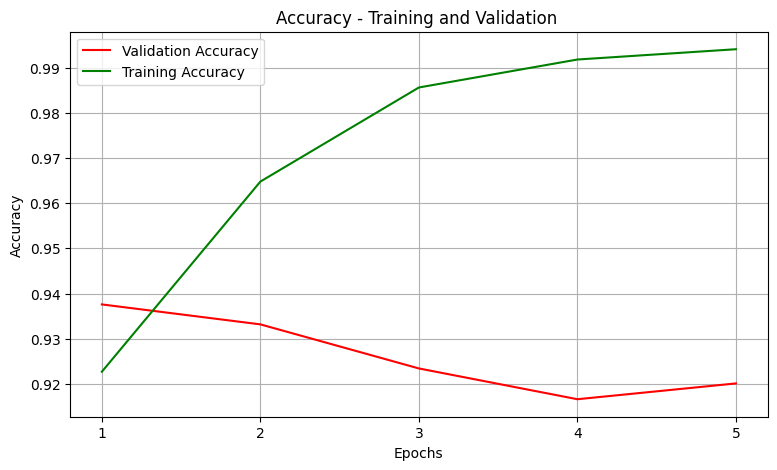

In [112]:
epochs_cnn = range(1, len(cnn_model_history.history['loss']) + 1)
accuracy_cnn = cnn_model_history.history['accuracy']
validation_accuracy_cnn = cnn_model_history.history['val_accuracy']
plt.figure(figsize=(9, 5))
plt.title('Accuracy - Training and Validation ')
plt.plot(epochs_cnn, validation_accuracy_cnn, 'r', label='Validation Accuracy',)
plt.plot(epochs_cnn, accuracy_cnn, 'g', label='Training Accuracy',)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend()

plt.xticks(range(1, 6))

plt.show()

## Fine-tuning model with pre-trained word-embedding

In [51]:
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer

ft_pe_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

train_data = ({"input_ids": X_train_pre["input_ids"], "attention_mask": X_train_pre["attention_mask"]}, y_train)
val_data = ({"input_ids": X_val_pre["input_ids"], "attention_mask": X_val_pre["attention_mask"]}, y_val)
test_data = ({"input_ids": X_test_pre["input_ids"], "attention_mask": X_test_pre["attention_mask"]}, y_test)

ft_pe_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

ft_pe_model_history = ft_pe_model.fit(train_data[0], train_data[1], validation_data=(val_data[0], val_data[1]), epochs=5, batch_size=8)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/5
5432/5432 [==============================] - 2868s 527ms/step - loss: 0.1941 - accuracy: 0.9275 - val_loss: 0.1644 - val_accuracy: 0.9381
Epoch 2/5
5432/5432 [==============================] - 2848s 524ms/step - loss: 0.1315 - accuracy: 0.9509 - val_loss: 0.1795 - val_accuracy: 0.9468
Epoch 3/5
5432/5432 [==============================] - 2816s 518ms/step - loss: 0.0814 - accuracy: 0.9719 - val_loss: 0.2058 - val_accuracy: 0.9398
Epoch 4/5
5432/5432 [==============================] - 2787s 513ms/step - loss: 0.0505 - accuracy: 0.9840 - val_loss: 0.2255 - val_accuracy: 0.9302
Epoch 5/5
5432/5432 [==============================] - 2771s 510ms/step - loss: 0.0377 - accuracy: 0.9886 - val_loss: 0.2807 - val_accuracy: 0.9391


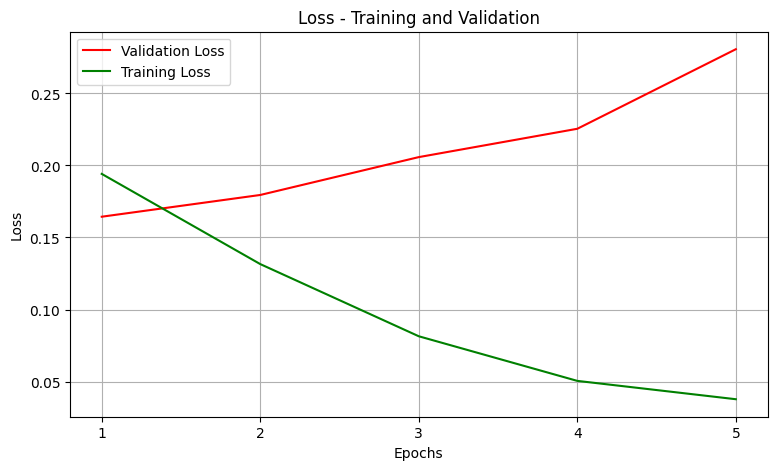

In [110]:
epochs_ft_pe = range(1, len(ft_pe_model_history.history['loss']) + 1)
loss_ft_pe = ft_pe_model_history.history['loss']
validation_loss_ft_pe = ft_pe_model_history.history['val_loss']
plt.figure(figsize=(9, 5))
plt.title('Loss - Training and Validation')
plt.plot(epochs_ft_pe, validation_loss_ft_pe, 'r', label='Validation Loss',)
plt.plot(epochs_ft_pe, loss_ft_pe, 'g', label='Training Loss',)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend()

plt.xticks(range(1, 6))

plt.show()

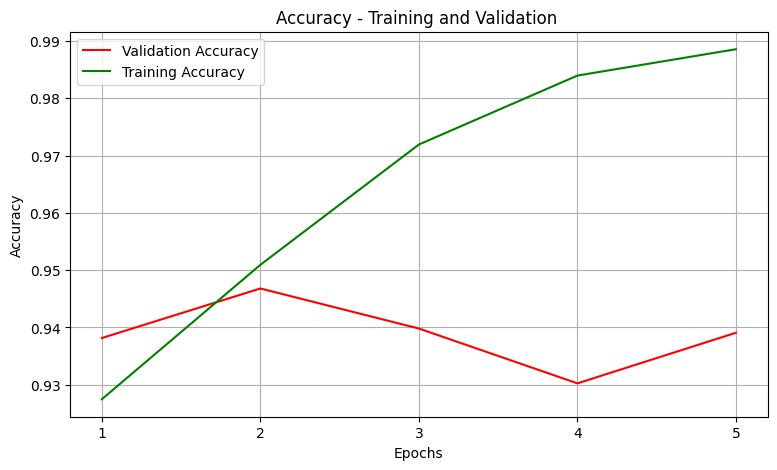

In [109]:
epochs_ft_pe = range(1, len(ft_pe_model_history.history['loss']) + 1)
accuracy_ft_pe = ft_pe_model_history.history['accuracy']
validation_accuracy_ft_pe = ft_pe_model_history.history['val_accuracy']
plt.figure(figsize=(9, 5))
plt.title('Accuracy - Training and Validation ')
plt.plot(epochs_ft_pe, validation_accuracy_ft_pe, 'r', label='Validation Accuracy',)
plt.plot(epochs_ft_pe, accuracy_ft_pe, 'g', label='Training Accuracy',)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend()

plt.xticks(range(1, 6))

plt.show()

## Fine-tuning language model 

In [250]:
ft_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

ft_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

ft_model_history = ft_model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=8)

Epoch 1/5
5432/5432 [==============================] - 6529s 1202ms/step - loss: 0.2230 - accuracy: 0.9177 - val_loss: 0.1943 - val_accuracy: 0.9280
Epoch 2/5
5432/5432 [==============================] - 6561s 1208ms/step - loss: 0.1587 - accuracy: 0.9408 - val_loss: 0.2009 - val_accuracy: 0.9249
Epoch 3/5
5432/5432 [==============================] - 6594s 1214ms/step - loss: 0.1375 - accuracy: 0.9496 - val_loss: 0.2066 - val_accuracy: 0.9260
Epoch 4/5
5432/5432 [==============================] - 6545s 1205ms/step - loss: 0.1244 - accuracy: 0.9547 - val_loss: 0.2122 - val_accuracy: 0.9216
Epoch 5/5
5432/5432 [==============================] - 6605s 1216ms/step - loss: 0.1155 - accuracy: 0.9570 - val_loss: 0.2294 - val_accuracy: 0.9207


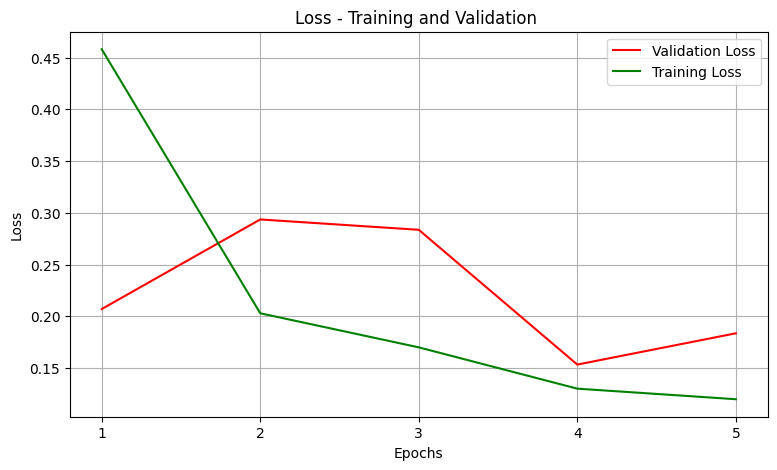

In [115]:
epochs_ft = range(1, len(ft_model_history.history['loss']) + 1)
loss_ft = ft_model_history.history['loss']
validation_loss_ft = ft_model_history.history['val_loss']
accuracy_ft = ft_model_history.history['accuracy']
validation_accuracy_ft = ft_model_history.history['accuracy']

plt.figure(figsize=(9, 5))
plt.title('Loss - Training and Validation ')
plt.plot(epochs_ft, validation_loss_ft, 'r', label='Validation Loss',)
plt.plot(epochs_ft, loss_ft, 'g', label='Training Loss',)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend()

plt.xticks(range(1, 6))

plt.show()

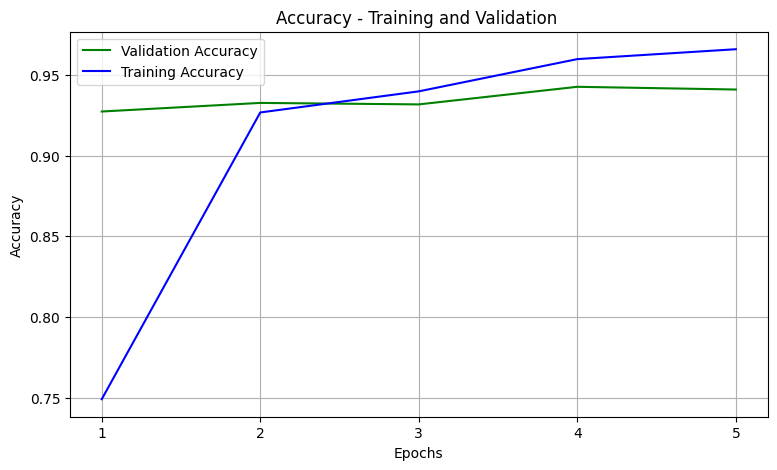

In [105]:
epochs_ft = range(1, len(ft_model_history.history['loss']) + 1)
accuracy_ft = ft_model_history.history['accuracy']
validation_accuracy_ft = ft_model_history.history['val_accuracy']
plt.figure(figsize=(9, 5))
plt.title('Accuracy - Training and Validation ')
plt.plot(epochs_ft, validation_accuracy_ft, 'g', label='Validation Accuracy',)
plt.plot(epochs_ft, accuracy_ft, 'b', label='Training Accuracy',)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend()

plt.xticks(range(1, 6))

plt.show()

#  Ewaluacja

Stworzono fukcję do uniwersalnej ewaluacji wyników w zależności od modelu

In [245]:
def plot_confusion_matrix(predictions, title):
    pred_labels = tf.cast(tf.squeeze(tf.round(predictions)), dtype=tf.int32)
    confusion = confusion_matrix(y_test, pred_labels)
    confusion_df = pd.DataFrame(confusion, index=['True Neutral', 'True Aggressive'], columns=['Predicted Neutral', 'Predicted Aggressive'])
    
    sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Greens")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()

def print_classification_report(predictions, message):
    print(message)
    pred_labels = tf.cast(tf.squeeze(tf.round(predictions)), dtype=tf.int32)
    print(classification_report(y_test, pred_labels, target_names=['Neutral','Aggressive']))

## Model LSTM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          3626368   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 3728305 (14.22 MB)
Trainable params: 3728305 (14.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Classification report for LSTM:
              precision    recall  f1-score  

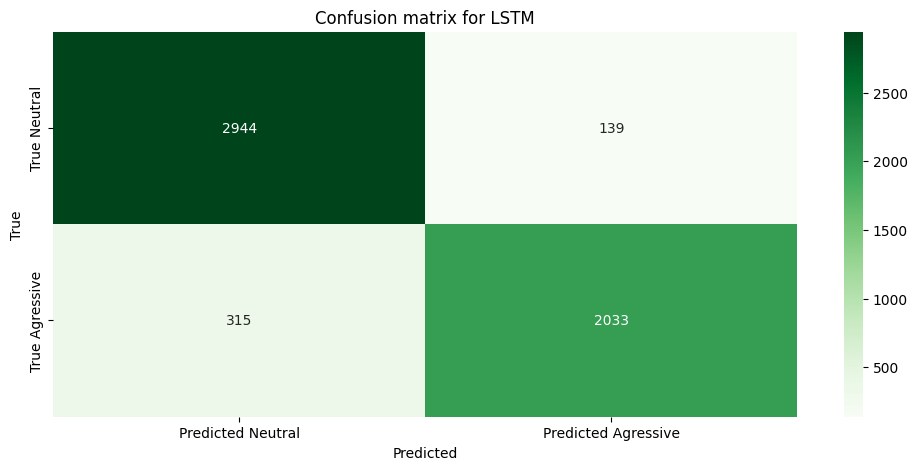

In [121]:
lstm_model_y_pred = lstm_model.predict(X_test)
# print(lstm_model.summary())
create_class_report(lstm_model_y_pred, "Classification report for LSTM:")
create_confusion_matrix(lstm_model_y_pred, 'Confusion matrix for LSTM')

## Model CNN

170/170 [==============================] - 1s 3ms/step
Classification report for CNN:
              precision    recall  f1-score   support

     Neutral       0.93      0.93      0.93      3083
   Agressive       0.90      0.90      0.90      2348

    accuracy                           0.92      5431
   macro avg       0.92      0.92      0.92      5431
weighted avg       0.92      0.92      0.92      5431



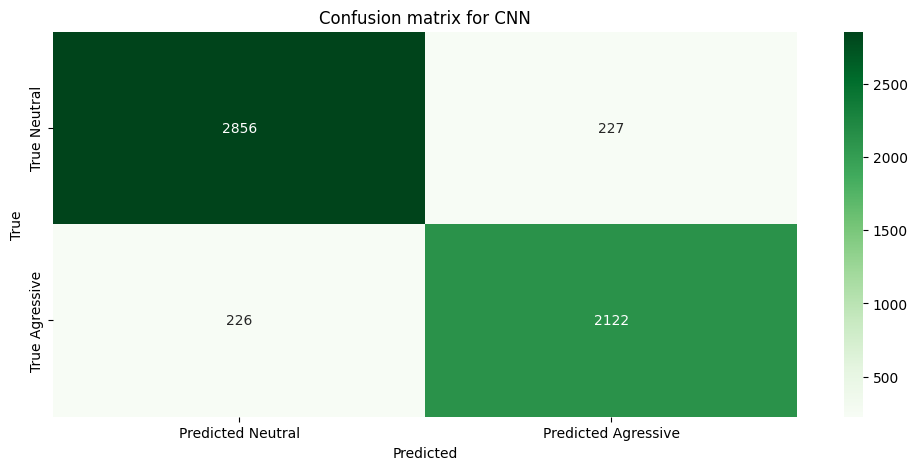

In [128]:
cnn_model_y_pred = cnn_model.predict(X_test)

create_class_report(cnn_model_y_pred, "Classification report for CNN:")
create_confusion_matrix(cnn_model_y_pred, 'Confusion matrix for CNN')

## Fine-tuning model with pre-trained word-embedding

Classification report for fine tuning model with pre-trained word embeddign:
              precision    recall  f1-score   support

     Neutral       0.92      0.92      0.92      3083
   Agressive       0.89      0.89      0.89      2348

    accuracy                           0.91      5431
   macro avg       0.91      0.91      0.91      5431
weighted avg       0.91      0.91      0.91      5431



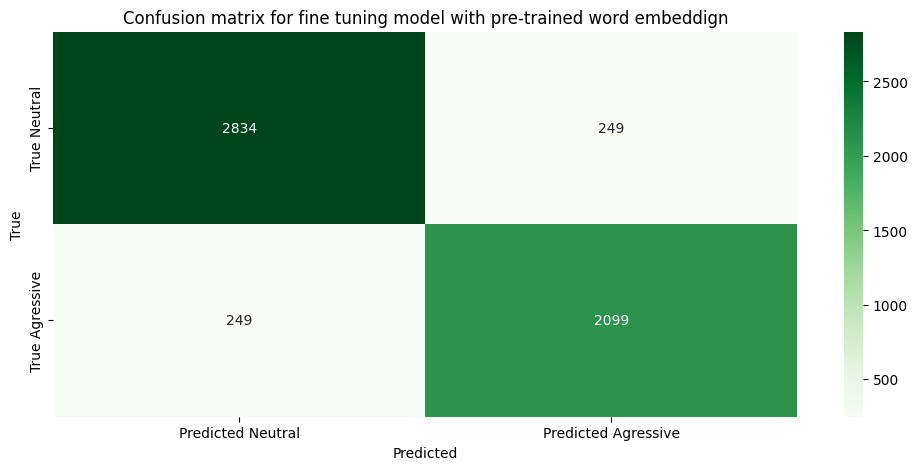

In [133]:
ft_pe_model_y_pred = ft_pe_model.predict(X_test)
predicted_labels = tf.argmax(ft_pe_model_y_pred.logits, axis=1).numpy()

create_class_report(predicted_labels, "Classification report for fine tuning model with pre-trained word embeddign:")
create_confusion_matrix(predicted_labels, 'Confusion matrix for fine tuning model with pre-trained word embeddign')

## Fine-tuning language model 

In [57]:
ft_model_y_pred = ft_model.predict(X_test)


170/170 [==============================] - 278s 2s/step


Classification report for fine tuning language model:
              precision    recall  f1-score   support

     Neutral       0.91      0.91      0.91      3083
   Agressive       0.88      0.89      0.88      2348

    accuracy                           0.90      5431
   macro avg       0.90      0.90      0.90      5431
weighted avg       0.90      0.90      0.90      5431



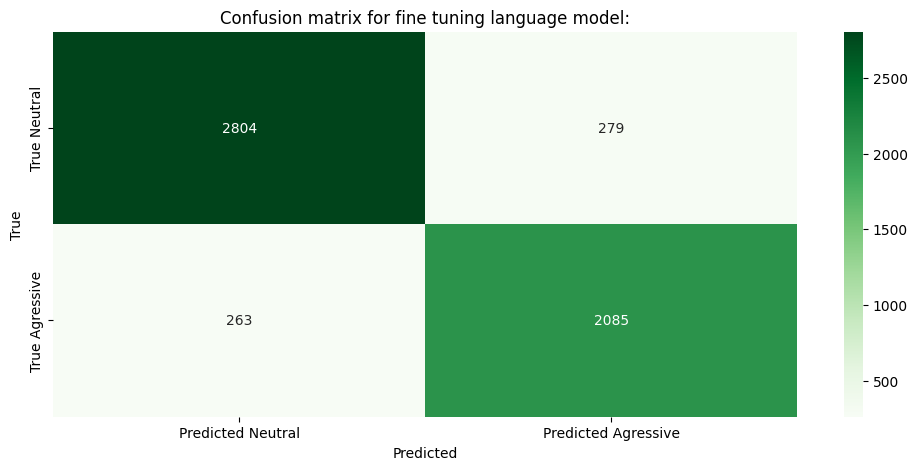

In [240]:
predicted_labels = tf.argmax(ft_model_y_pred.logits, axis=1).numpy()

create_class_report(predicted_labels, "Classification report for fine tuning language model:")
create_confusion_matrix(predicted_labels, 'Confusion matrix for fine tuning language model:')

# Wnioski i obserwacje


Ze względu na bardzo duży dataset trenowanie modeli było bardzo trudne. Rekordowo jeden trening zajął mi ponad 8 godzin. Taki długi czas trenowania uniemożliwił mi lepszą hiperparametryzacje oraz rozbudowe sieci. Jednakże każdy z modeli poprawnie spełnia swoją funkcję. Udało się osiągnąć wysoki współczynnik accuracy w kązdym modelu. Ze względu na bardzo długi czas trenowania modelu językowego oraz modelu z pre-trained word embedingiem nie byłem w stanie tak dokładnie wykonać hiperparametryzacji przez co accuracy dla tych modeli jest delikatnie niższe niż dla LSTM oraz CNN. Zaskakujaco dobrze radzą sobie tak proste modele CNN oraz LSTM. Na podstawie funkcji straty można zaobserwować że zmniejszenie liczby epok, zastosowanie early stopów lub dalsza rozbudowa sieci, regularyzacja mogłaby jeszcze lepiej usprawnić te modele.

W przyszłości istnieje możliwość rozbudowy tych modeli poprzez wykorzystanie technik takich jak K-Fold Cross Validation czy Grid Search, w celu znalezienia optymalnych hiperparametrów. Niestety, ze względu na ograniczenia techniczne oraz brak dostępu do chmury obliczeniowej, nie mogłem tego zrealizować. Dodatkowo, istnieje potencjał dla bardziej szczegółowej analizy początkowych danych, z uwzględnieniem specyfiki języka i środowiska, z którego zostały zebrane te dane. Przykładowo, w moim przypadku, w zbiorze znajdowało się wiele tweetów od osób popierających prezydenta Trumpa oraz dotyczących kwestii związanych z kontrolą broni

# Klasyfikacja

Ponieżej zaprezentowano klasyfikacje tweetów dla konkretnych modeli

In [241]:
def classify(model, text):
    tokens = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')(text, truncation=True, padding=True, return_tensors='tf')
    input_ids = tokens["input_ids"].numpy().flatten()
    padded_sequences = pad_sequences([input_ids], maxlen=max_len, padding='post', truncating='post')
    predictions = model.predict(padded_sequences)
    pred = tf.nn.softmax(predictions.logits if hasattr(predictions, "logits") else predictions, axis=-1)
    predykcja = np.argmax(pred.numpy())
    if predykcja == 0:
        return f"Tweet is not toxic"
    else:
        return f"Tweet is toxic"

In [242]:

print(classify(lstm_model, "you've gone and broke the wrong heart baby, and drove me redneck crazy"))
print(classify(cnn_model, "you've gone and broke the wrong heart baby, and drove me redneck crazy"))
print(classify(ft_pe_model, "you've gone and broke the wrong heart baby, and drove me redneck crazy"))
print(classify(ft_model, "you've gone and broke the wrong heart baby, and drove me redneck crazy"))


1/1 [==============================] - 0s 459ms/step
Tweet is not toxic
1/1 [==============================] - 0s 17ms/step
Tweet is not toxic
1/1 [==============================] - 0s 178ms/step
Tweet is not toxic
1/1 [==============================] - 0s 66ms/step
Tweet is not toxic


In [243]:
print(classify(lstm_model, "you got wild bitches tellin you lies"))
print(classify(cnn_model, "you got wild bitches tellin you lies"))
print(classify(ft_pe_model, "you got wild bitches tellin you lies"))
print(classify(ft_model, "you got wild bitches tellin you lies"))

1/1 [==============================] - 0s 172ms/step
Tweet is toxic
1/1 [==============================] - 0s 70ms/step
Tweet is toxic
1/1 [==============================] - 0s 80ms/step
Tweet is toxic
1/1 [==============================] - 0s 68ms/step
Tweet is toxic
